<a href="https://colab.research.google.com/github/rajusuthar/Twitter-sentiment-analysis/blob/main/Copy_of_Assignment_Support_Vector_Machine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <u><b> Objective </b></u>
## <b> You are given a data of US Airline tweets and their sentiment. The task is to do sentiment analysis about the problems of each major U.S. airline. Twitter data was scraped from February of 2015 and contributors were asked to first classify positive, negative, and neutral tweets, followed by categorizing negative reasons (such as "late flight" or "rude service"). </b>

<br>
<br>

## <b>Things to do :</b>
* ### Read the tweets.csv data, clean and tokenize the tweets using nltk library.
* ### Count vectorize the tweets so that you end up with a sparse matrix (which will be your $X$). 
* ### You are supposed to build a SVM classifier (a binary classification in fact). Since the data contains three levels of sentiment(positive, negative and neutral), you should remove the sentences which are neutral. Once you do that you will have two classes only (positive and negative). You can set the label of positive tweets to 1 and negative tweets to 0.
* ### Once you have built the SVM classifier, evaluate this model across various metrics. Also plot the ROC curve and Precision-Recall curve. Report the areas under these two curves along with other metrics.
* ### Perform GridSearch cross validation for various values of $C$ and $gamma$. These will be the hyperparameters which you would play around with.
* ### Explain your observations and the underlying reasons for these.
* ### Try checking if <code>tfidfvectorizer</code> helps you gain lift in model's performance.





In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#importing library
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [4]:
#creating directory path
dir_path='/content/drive/MyDrive/Tweets.csv'

In [5]:
#reading data
tweet_df=pd.read_csv(dir_path)

In [6]:
tweet_df.shape

(14640, 15)

#We only need data where sentiment is positive or nagative so let's remove rows where sentiment is nagetive

In [7]:
#consider row where sentiment is positive or nagetive
tweet_df=tweet_df[tweet_df['airline_sentiment']!='neutral']

In [8]:
tweet_df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)


In [9]:
#cheking for null value
tweet_df.isnull().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   2363
negativereason_confidence        2033
airline                             0
airline_sentiment_gold          11504
name                                0
negativereason_gold             11509
retweet_count                       0
text                                0
tweet_coord                     10703
tweet_created                       0
tweet_location                   3771
user_timezone                    3849
dtype: int64

#In our data ,in columns like negativereason_gold ,airline_sentiment_gold,tweet_coord have many null value and also some column like name of user,timezone.location,retweet_count not impact our analysis or i would say not impact user review so let's remove these columns from our dataframe.

In [10]:
#dropping columns
tweet_df.drop('negativereason_gold', axis=1, inplace=True)
tweet_df.drop('airline_sentiment_gold', axis=1, inplace=True)
tweet_df.drop('retweet_count', axis=1, inplace=True)
tweet_df.drop('tweet_coord', axis=1, inplace=True)
tweet_df.drop('tweet_location', axis=1, inplace=True)
tweet_df.drop('tweet_created', axis=1, inplace=True)
tweet_df.drop('user_timezone', axis=1, inplace=True)
tweet_df.drop('name', axis=1, inplace=True)

In [11]:
tweet_df['airline'].value_counts()

United            3125
US Airways        2532
American          2296
Southwest         1756
Delta             1499
Virgin America     333
Name: airline, dtype: int64

#We have data of five airlines

In [12]:
tweet_df['airline_sentiment'].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

#Our data consits of more nagative reviews

In [13]:
tweet_df['negativereason'].value_counts()

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

#Most of the time customer gives nagative reviews becuase of customer behaviour

#**Test data cleaning**

#In our text columns we have word which are common also punctuation so let's remove common/stop word and punctuation from text columns

In [14]:
#importing libraray and downloading stopword
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [15]:
#importing library
import string
from nltk.corpus import stopwords

In [16]:
def clean_text(str_in):

    res = ""
    str_in = str_in.lower()
    str_arr = str_in.split(' ')
    for word in str_arr:
        # make all words into lower case
        word = word.lower()
        # remove not useful words from the original text
        if '@' in word or word == '' or word[:1] == '&':
            continue
        if word.lower() in stopwords.words('english'):
            continue
        if word.isnumeric():
            continue
        res = res + " " + word
    return res

In [17]:
#applying funtion to text column to clean text data
tweet_df['text'] =tweet_df['text'].apply(clean_text)

In [18]:
tweet_df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,text
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,plus added commercials experience... tacky.
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,"really aggressive blast obnoxious ""entertainm..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,really big bad thing
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,seriously would pay $30 flight seats playing....
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,"yes, nearly every time fly vx “ear worm” won’..."
...,...,...,...,...,...,...,...
14633,569587705937600512,negative,1.0000,Cancelled Flight,1.0000,American,"flight cancelled flightled, leaving tomorrow ..."
14634,569587691626622976,negative,0.6684,Late Flight,0.6684,American,right cue delays👌
14635,569587686496825344,positive,0.3487,NaN,0.0000,American,thank got different flight chicago.
14636,569587371693355008,negative,1.0000,Customer Service Issue,1.0000,American,leaving minutes late flight. warnings communi...


#**Data Analysis**

In [19]:
tweet_df.groupby('airline_sentiment')['airline_sentiment_confidence'].sum()

airline_sentiment
negative    8566.4269
positive    2060.6280
Name: airline_sentiment_confidence, dtype: float64

#We have more airline_sentiment_confidence it mean we have more nagative tweet

#Now let's see which airlines is worst

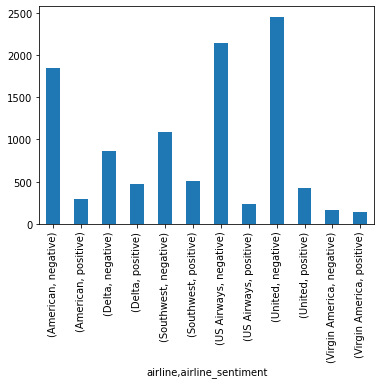

In [20]:
tweet_df.groupby(['airline','airline_sentiment'])['airline_sentiment_confidence'].sum().plot(kind='bar')

#From above bar plot we can say that United airlines has maximum nagative tweet or reviews

#Let's build model 

In [21]:
#Creating a function
def retrun_z(strr):
  '''
  This function take string as input and if string is postive return 1 else 0
  '''
  if strr=='positive':
    return 1
  else:
    return 0

In [22]:
#converting airline_sentiment into numeric
tweet_df['airline_sentiment']=tweet_df['airline_sentiment'].apply(retrun_z)

In [23]:
#doing vectorization using count vectorization
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
vectorizer = CountVectorizer(max_df = 0.9,min_df = 10)


In [24]:
#splitting data into train and test
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(tweet_df['text'],tweet_df['airline_sentiment'],test_size=0.2)

In [25]:
#vectorizing train and test data
vectorized_train=vectorizer.fit_transform(X_train)
vectorized_test=vectorizer.transform(X_test)

In [26]:
#converting verctorized data to array 
train_array= vectorized_train.toarray()
test_array = vectorized_test.toarray()

In [27]:
#importing support vector machine classifier
from sklearn.svm import SVC
clf = SVC(kernel='rbf', C=1E6)
clf.fit(train_array,y_train)

SVC(C=1000000.0)

In [28]:
#prediction
y_train_pred=clf.predict(train_array)
y_test_pred=clf.predict(test_array)

In [29]:
#evaluting using roc auc
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

# auc score
print('test accuracy score:',accuracy_score(y_test,y_test_pred))
print('train accuracy score:',accuracy_score(y_train,y_train_pred))
print('test roc auc  score:',roc_auc_score(y_test,y_test_pred))
print('train train roc auc score:',roc_auc_score(y_train,y_train_pred))



test accuracy score: 0.8796015591165006
train accuracy score: 0.9974003466204506
test roc auc  score: 0.8004807799866661
train train roc auc score: 0.9939849399136581


In [30]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test,y_test_pred, pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_train,y_train_pred, pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


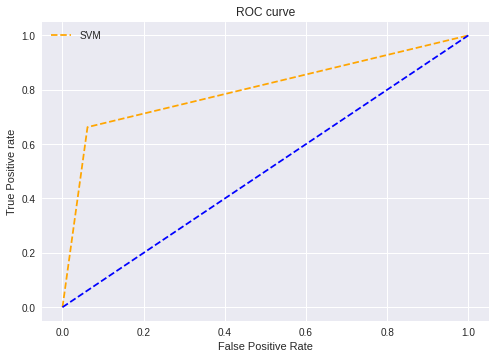

In [31]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='SVM')

plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

#Using tfidvectorizer if in can improve test result

In [32]:
#vectorizing
tf_vectorizer = TfidfVectorizer()
tf_train_vectors = vectorizer.fit_transform(X_train)
tf_test_vectors = vectorizer.transform(X_test)

In [33]:
#converting verctorized data to array 
tf_train_array= tf_train_vectors.toarray()
tf_test_array = tf_test_vectors.toarray()

#importing support vector machine classifier
from sklearn.svm import SVC
clf_tf = SVC(kernel='rbf', C=1E6)
clf_tf.fit(tf_train_array,y_train)

SVC(C=1000000.0)

In [34]:
#prediction
y_train_pred_tf=clf_tf.predict(tf_train_array)
y_test_pred_tf=clf_tf.predict(tf_test_array)

In [35]:
#evaluting using roc auc
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

# auc score
print('test accuracy score:',accuracy_score(y_test,y_test_pred_tf))
print('train accuracy score:',accuracy_score(y_train,y_train_pred_tf))
print('test roc auc  score:',roc_auc_score(y_test,y_test_pred_tf))
print('train train roc auc score:',roc_auc_score(y_train,y_train_pred_tf))

test accuracy score: 0.8796015591165006
train accuracy score: 0.9974003466204506
test roc auc  score: 0.8004807799866661
train train roc auc score: 0.9939849399136581


In [37]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred_tf))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1817
           1       0.74      0.66      0.70       492

    accuracy                           0.88      2309
   macro avg       0.83      0.80      0.81      2309
weighted avg       0.88      0.88      0.88      2309



In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92      1817
           1       0.74      0.66      0.70       492

    accuracy                           0.88      2309
   macro avg       0.83      0.80      0.81      2309
weighted avg       0.88      0.88      0.88      2309



#Vectorization performing better than tfidfvectorizer

#performing grid search cv

In [40]:
from sklearn.model_selection import GridSearchCV
 
# defining parameter range
param_grid = {'C': [0.1, 1,1000,100000],
              'gamma': [1, 0.1, 0.0001,10,100],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid,cv=2)
 
# fitting the model for grid search
grid.fit(train_array,y_train)

GridSearchCV(cv=2, estimator=SVC(),
             param_grid={'C': [0.1, 1, 1000, 100000],
                         'gamma': [1, 0.1, 0.0001, 10, 100],
                         'kernel': ['rbf']})

In [41]:
#prediction
grid_y_train_pred_tf=grid.predict(train_array)
grid_y_test_pred_tf=grid.predict(test_array)

In [43]:
#evaluting using roc auc
from sklearn.metrics import accuracy_score,confusion_matrix,roc_auc_score

# auc score
print('test accuracy score:',accuracy_score(y_test,grid_y_test_pred_tf))
print('train accuracy score:',accuracy_score(y_train,grid_y_train_pred_tf))
print('test roc auc  score:',roc_auc_score(y_test,grid_y_test_pred_tf))
print('train train roc auc score:',roc_auc_score(y_train,grid_y_train_pred_tf))

test accuracy score: 0.8999566912083153
train accuracy score: 0.9352253032928943
test roc auc  score: 0.8082266176266606
train train roc auc score: 0.8653056239671849


In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test,grid_y_test_pred_tf))

              precision    recall  f1-score   support

           0       0.91      0.97      0.94      1817
           1       0.85      0.65      0.73       492

    accuracy                           0.90      2309
   macro avg       0.88      0.81      0.84      2309
weighted avg       0.90      0.90      0.89      2309

